In [1]:
# Install Ultralytics YOLOv8 and Optuna
!pip install -q ultralytics optuna

# (Optional) Restart runtime if needed after install

from ultralytics import YOLO
import optuna

# Verify that YOLOv8 is ready



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.7 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
from IPython.display import clear_output  # Clear outputs
import os
import subprocess
import optuna
import random
import numpy as np
from sklearn.model_selection import StratifiedKFold
import torch

# Clear outputs and verify setup
clear_output()
print('Setup complete. Using torch %s %s' % (
    torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


Setup complete. Using torch 2.5.1+cu121 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16269MB, multi_processor_count=56, uuid=d3a8997b-b3eb-6b9b-557c-556f33961399, L2_cache_size=4MB)


In [3]:
# Calculate class weights
class_counts =  [1778, 2399, 4196, 4233, 2657, 1393, 2357, 3220, 3367]
  # Replace with the number of samples per class
total = sum(class_counts)
weights = [total / c for c in class_counts]
normalized_weights = [w / sum(weights) for w in weights]
print("Class weights:", normalized_weights)


Class weights: [0.1571077353391078, 0.11643916358188149, 0.06657234352548466, 0.06599044494045209, 0.10513268853328328, 0.20052947123685116, 0.1185140235184275, 0.0867507929915943, 0.08296333633291764]


In [4]:
from sklearn.model_selection import KFold
import os
import random  # ✅ Add this

# Paths to dataset
images_path = "/kaggle/input/datasett/llllasstt/ODS_New/images"
labels_path = "/kaggle/input/datasett/llllasstt/ODS_New/labels"

# Dynamically determine the number of folds (k)
total_images = len([f for f in os.listdir(images_path) if f.endswith(".jpg")])
k = 5

print(f"Total images: {total_images}, Number of folds: {k}")

# Get all image files and corresponding labels
images = sorted([f for f in os.listdir(images_path) if f.endswith(".jpg")])
labels = sorted([f for f in os.listdir(labels_path) if f.endswith(".txt")])
print(f"Number of images: {len(images)}, Number of labels: {len(labels)}")

# K-Fold for object detection
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Create folds
folds = list(kf.split(images))
print(f"K-Fold created with {k} folds.")

# Display fold information
for fold_idx, (train_idx, val_idx) in enumerate(folds):
    print(f"Fold {fold_idx + 1}:")
    print(f"  Train size: {len(train_idx)}, Validation size: {len(val_idx)}")

    # ✅ Set seed for consistent inner shuffling
    random.seed(42)

    # Shuffle the indices (inner shuffle)
    train_idx = random.sample(train_idx.tolist(), len(train_idx))
    val_idx = random.sample(val_idx.tolist(), len(val_idx))

    # Now you can pass train_idx, val_idx to your fold-creation function


Total images: 9165, Number of folds: 5
Number of images: 9165, Number of labels: 9165
K-Fold created with 5 folds.
Fold 1:
  Train size: 7332, Validation size: 1833
Fold 2:
  Train size: 7332, Validation size: 1833
Fold 3:
  Train size: 7332, Validation size: 1833
Fold 4:
  Train size: 7332, Validation size: 1833
Fold 5:
  Train size: 7332, Validation size: 1833


In [5]:
import shutil
import os

# Path to the folds directory
folds_dir = "/kaggle/working/folds"


# Create data.yaml file for each fold, including class weights
import os
import shutil

# Function to split and save dataset for each fold
def create_fold_directories(images, labels, train_idx, val_idx, fold_dir):
    # Create train and val directories
    os.makedirs(f"{fold_dir}/train/images", exist_ok=True)
    os.makedirs(f"{fold_dir}/train/labels", exist_ok=True)
    os.makedirs(f"{fold_dir}/val/images", exist_ok=True)
    os.makedirs(f"{fold_dir}/val/labels", exist_ok=True)

    # Copy training data
    for idx in train_idx:
        shutil.copy(os.path.join(images_path, images[idx]), f"{fold_dir}/train/images/")
        shutil.copy(os.path.join(labels_path, labels[idx]), f"{fold_dir}/train/labels/")

    # Copy validation data
    for idx in val_idx:
        shutil.copy(os.path.join(images_path, images[idx]), f"{fold_dir}/val/images/")
        shutil.copy(os.path.join(labels_path, labels[idx]), f"{fold_dir}/val/labels/")

# Create data.yaml file for each fold, including class weights
for fold, (train_idx, val_idx) in enumerate(folds):
    print(f"Creating data.yaml and dataset for Fold {fold + 1}...")

    # Directory for the current fold
    fold_dir = f"/kaggle/working/folds/fold_{fold}"
    os.makedirs(fold_dir, exist_ok=True)  # Ensure the fold directory exists

    # Shuffle the training and validation indices for randomness
    train_idx = random.sample(train_idx.tolist(), len(train_idx))
    val_idx = random.sample(val_idx.tolist(), len(val_idx))

    # Split and create directories for this fold
    create_fold_directories(images, labels, train_idx, val_idx, fold_dir)

    # Define paths dynamically for each fold
    train_path = f"{fold_dir}/train/images"
    val_path = f"{fold_dir}/val/images"
    test_path = "/kaggle/input/testtt/images"  # Path to your test dataset

    # Create and write the data.yaml file
    fold_data_yaml = f"{fold_dir}/data.yaml"
    with open(fold_data_yaml, "w") as file:
        file.write(f"""
train: {train_path}
val: {val_path}
test: {test_path}

nc: 9
names: ['bicycle', 'bus','car','Toktok',Motorbike','Minibus','Truck','Potholes','bumps']
weights: {normalized_weights}  # Include the normalized class weights here
""")
    print(f"data.yaml and dataset created for Fold {fold + 1} at {fold_data_yaml}")






Creating data.yaml and dataset for Fold 1...
data.yaml and dataset created for Fold 1 at /kaggle/working/folds/fold_0/data.yaml
Creating data.yaml and dataset for Fold 2...
data.yaml and dataset created for Fold 2 at /kaggle/working/folds/fold_1/data.yaml
Creating data.yaml and dataset for Fold 3...
data.yaml and dataset created for Fold 3 at /kaggle/working/folds/fold_2/data.yaml
Creating data.yaml and dataset for Fold 4...
data.yaml and dataset created for Fold 4 at /kaggle/working/folds/fold_3/data.yaml
Creating data.yaml and dataset for Fold 5...
data.yaml and dataset created for Fold 5 at /kaggle/working/folds/fold_4/data.yaml


In [ ]:
import shutil
import yaml
import os

# Your custom hyperparameters
custom_hyp = {
    'lr0': 0.001671064710347394,
    'weight_decay': 2.2685757314775693e-05,
    'momentum': 0.8503824687426746,
    'iou_t': 0.43797375167111124,
    'conf_thres': 0.38692552268337177
}

# File paths
hyp_source = "/kaggle/input/hypppp/temp_hyp_2 (1).yaml"   # Read-only source
hyp_target = "/kaggle/working/temp_hyp.yaml"              # Writable target

# Step 1: Copy from input (read-only) to working (writable)
shutil.copyfile(hyp_source, hyp_target)

# Step 2: Load, update, and write
with open(hyp_target, "r") as f:
    hyp_data = yaml.safe_load(f)

hyp_data.update(custom_hyp)

with open(hyp_target, "w") as f:
    yaml.dump(hyp_data, f, default_flow_style=False)

print("✅ Hyperparameters updated and saved to:", hyp_target)


In [ ]:
import os
import yaml
import pandas as pd
from ultralytics import YOLO

# ✅ Define your hyperparameters
custom_hyp = {
    'lr0': 0.0075,
    'weight_decay': 2.2685757314775693e-05,
    'momentum': 0.8503824687426746,
    'iou': 0.43797375167111124,        # changed from iou_t
    'conf': 0.38692552268337177        # changed from conf_thres
}

# ✅ Paths
base_data_dir = "/kaggle/working/folds/fold_{}"
weights = "yolov8m.pt"  # You can use yolov8n.pt, yolov8s.pt, etc.
project_dir = "/kaggle/working/fold_runs"
metrics_dir = "/kaggle/working/metrics"
os.makedirs(metrics_dir, exist_ok=True)

# ✅ Training settings
epochs = 95
batch_size = 32
imgsz = 480

# ✅ Loop through folds
for fold in [2]:
    torch.cuda.empty_cache()
    print(f"\n📦 Starting Fold {fold}...")

    # Paths
    data_yaml = base_data_dir.format(fold) + "/data.yaml"
    run_name = f"fold_{fold}"
    run_path = os.path.join(project_dir, run_name)

    # ✅ Load YOLOv8 model
    model = YOLO(weights)

    # ✅ Train the model
    print(f"🚀 Training Fold {fold}...\n")
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch_size,
        project=project_dir,
        name=run_name,
        half=True,
        verbose=True,
        augment=True,
        workers=2,
        patience=5, 
        exist_ok=True,
        **custom_hyp
    )

    print(f"✅ Fold {fold} Training Complete.")

    # ✅ Load and process metrics
    results_json_path = os.path.join(run_path, "results.json")
    if os.path.exists(results_json_path):
        with open(results_json_path, "r") as f:
            results_json = json.load(f)

        print(f"\n📊 Fold {fold} — Class-wise Metrics:")
        df = pd.DataFrame(results_json["metrics"])
        df.index.name = "Class Index"

        if "names" in results_json:
            df["Class Name"] = pd.Series(results_json["names"])

        display(df[["Class Name", "precision", "recall", "mAP_0.5", "mAP_0.5:0.95"]])

        # Save per-class metrics CSV
        class_csv_path = os.path.join(metrics_dir, f"fold_{fold}_per_class.csv")
        df.to_csv(class_csv_path, index=True)
        print(f"📁 Saved per-class metrics to: {class_csv_path}")

        # Save overall metrics
        overall_avg = df[["precision", "recall", "mAP_0.5", "mAP_0.5:0.95"]].mean().to_frame().T
        overall_avg["Fold"] = fold
        overall_csv_path = os.path.join(metrics_dir, f"fold_{fold}_overall.csv")
        overall_avg.to_csv(overall_csv_path, index=False)
        print(f"📁 Saved overall metrics to: {overall_csv_path}")
    else:
        print(f"⚠️ No results.json found at {results_json_path}")



📦 Starting Fold 2...
🚀 Training Fold 2...

Ultralytics 8.3.160 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.38692552268337177, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/folds/fold_2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=95, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.43797375167111124, keras=False, kobj=1.0, line_width=None, lr0=0.0075, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.8503824687426746, mosaic=1.0, multi_scale=False, name=fold_2, nbs=64, nms=False, opset=None, optim

train: Scanning /kaggle/working/folds/fold_2/train/labels... 7332 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7332/7332 [00:06<00:00, 1137.97it/s]

train: /kaggle/working/folds/fold_2/train/images/273275-ae4d80000fc9116e_jpg.rf.3162d5dce9a6b298bfaad67e474b9f70.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/folds/fold_2/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 5, len(boxes) = 17559. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 832.5±594.2 MB/s, size: 436.8 KB)


val: Scanning /kaggle/working/folds/fold_2/val/labels... 1833 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1833/1833 [00:01<00:00, 1074.88it/s]

val: New cache created: /kaggle/working/folds/fold_2/val/labels.cache


Plotting labels to /kaggle/working/fold_runs/fold_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0075' and 'momentum=0.8503824687426746' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=2.2685757314775693e-05), 83 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to /kaggle/working/fold_runs/fold_2
Starting training for 95 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/95       8.3G       1.27      1.886      1.246         17        480: 100%|██████████| 230/230 [02:30<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.96it/s]

                   all       1833       4355      0.721      0.587      0.672      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/95      7.62G      1.182      1.128       1.16         24        480: 100%|██████████| 230/230 [02:30<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1833       4355      0.786      0.649      0.741      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/95      7.62G       1.19      1.091      1.157          9        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]

                   all       1833       4355      0.761        0.6      0.703      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/95      7.62G      1.214      1.101      1.188         18        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.20it/s]

                   all       1833       4355      0.752      0.663      0.735      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/95      7.62G      1.199      1.043       1.17         24        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all       1833       4355      0.813      0.619       0.73      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/95      7.62G      1.179      1.012      1.161         18        480: 100%|██████████| 230/230 [02:29<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1833       4355      0.781      0.677      0.752      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/95      7.62G      1.171     0.9663      1.159         42        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all       1833       4355        0.8       0.67      0.747      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/95      7.62G      1.157     0.9373       1.15         13        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all       1833       4355      0.837      0.676      0.777      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/95      7.62G       1.13     0.9115      1.139         13        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.17it/s]

                   all       1833       4355      0.785      0.686      0.761      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/95      7.62G      1.123      0.885      1.127         10        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1833       4355      0.832      0.701       0.79      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/95      7.62G      1.117      0.869      1.133         13        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.13it/s]

                   all       1833       4355      0.823      0.712      0.783      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/95      7.62G      1.103     0.8582      1.123         35        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.14it/s]

                   all       1833       4355      0.825       0.72        0.8        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/95      7.62G      1.088     0.8283      1.117         12        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1833       4355      0.841      0.734      0.813      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/95      7.62G      1.072     0.8217      1.104          9        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all       1833       4355      0.832      0.717      0.802      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/95      7.62G      1.076     0.8101      1.114         28        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1833       4355      0.829      0.716      0.798      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/95      7.62G      1.066     0.7895      1.104         10        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1833       4355      0.832      0.728      0.806      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/95      7.62G      1.047      0.771      1.093         12        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.17it/s]

                   all       1833       4355       0.84       0.74      0.815      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/95      7.62G      1.037     0.7657      1.092         11        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.17it/s]

                   all       1833       4355      0.844      0.734      0.816      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/95      7.62G      1.038     0.7582      1.092         17        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.13it/s]

                   all       1833       4355      0.835      0.745      0.822      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/95      7.62G      1.021      0.742      1.084         11        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.13it/s]

                   all       1833       4355       0.81      0.785      0.832      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/95      7.62G       1.02     0.7318      1.083         19        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]

                   all       1833       4355      0.827      0.771      0.831      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/95      7.62G      1.011     0.7195      1.075         12        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]

                   all       1833       4355      0.823      0.769      0.829       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/95      7.62G     0.9998     0.7039      1.071         14        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1833       4355      0.834       0.76       0.83      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/95      7.62G     0.9933     0.7026      1.064         18        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.862      0.765      0.837      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/95      7.62G     0.9856     0.6805      1.059         12        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.13it/s]

                   all       1833       4355      0.848      0.766      0.837      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/95      7.62G     0.9797      0.676      1.058         40        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1833       4355      0.841      0.784      0.842       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/95      7.62G     0.9758     0.6717      1.057         57        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.14it/s]

                   all       1833       4355      0.828      0.781      0.837      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/95      7.62G     0.9627     0.6604       1.05         24        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.14it/s]

                   all       1833       4355      0.836      0.781      0.837      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/95      7.63G      0.956     0.6529      1.049         22        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.837      0.792      0.846      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/95      7.63G     0.9652     0.6537      1.052         21        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.13it/s]

                   all       1833       4355       0.85      0.781      0.845      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/95      7.63G     0.9421      0.632      1.039         19        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.09it/s]

                   all       1833       4355      0.853      0.782      0.847      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/95      7.63G     0.9324     0.6263      1.036         12        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.12it/s]

                   all       1833       4355      0.851      0.787      0.848      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/95      7.63G     0.9358     0.6225      1.037         18        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.863      0.779      0.846      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/95      7.63G     0.9298     0.6192      1.036         10        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1833       4355      0.855      0.792      0.849      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/95      7.63G     0.9301     0.6137      1.033         10        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.863       0.78      0.848      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/95      7.63G     0.9168     0.5985      1.027         35        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.13it/s]

                   all       1833       4355      0.848      0.798      0.855      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/95      7.63G     0.9005     0.5874      1.018         11        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.12it/s]

                   all       1833       4355      0.868        0.8      0.861       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/95      7.63G     0.9004     0.5851      1.016         17        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.14it/s]

                   all       1833       4355      0.865      0.804      0.865      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/95      7.63G     0.8937     0.5798      1.015         20        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.09it/s]

                   all       1833       4355      0.855      0.799      0.857      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/95      7.63G     0.8885     0.5695      1.014         14        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.07it/s]

                   all       1833       4355      0.853      0.809       0.86      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/95      7.63G     0.8805     0.5696      1.011         22        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1833       4355      0.861      0.796      0.855      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/95      7.63G      0.875     0.5608      1.005          7        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.14it/s]

                   all       1833       4355      0.867      0.804      0.861      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/95      7.63G     0.8729     0.5567      1.009         34        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.14it/s]

                   all       1833       4355      0.864      0.788      0.855      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/95      7.63G     0.8637     0.5505      1.005         12        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.13it/s]

                   all       1833       4355      0.858        0.8      0.858      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/95      7.63G      0.866     0.5542      1.003         19        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.863      0.804      0.864      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/95      7.63G     0.8583     0.5381     0.9978         21        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.12it/s]

                   all       1833       4355      0.846      0.808      0.856      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/95      7.63G     0.8554     0.5376     0.9962         52        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]

                   all       1833       4355      0.859      0.805      0.864      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/95      7.63G     0.8521     0.5321     0.9964         42        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.08it/s]

                   all       1833       4355      0.844      0.812       0.86      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/95      7.63G     0.8391     0.5231     0.9892         46        480: 100%|██████████| 230/230 [02:29<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]

                   all       1833       4355       0.87      0.794      0.861       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/95      7.63G     0.8416     0.5215     0.9874         12        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.856        0.8      0.856      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/95      7.63G     0.8287     0.5102     0.9815          8        480: 100%|██████████| 230/230 [02:29<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.12it/s]

                   all       1833       4355      0.843      0.815      0.863      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/95      7.63G     0.8227     0.5024     0.9843         17        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]

                   all       1833       4355       0.87      0.799      0.862       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/95      7.63G     0.8189     0.5064     0.9788         11        480: 100%|██████████| 230/230 [02:29<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.12it/s]

                   all       1833       4355      0.869      0.791      0.861      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/95      7.63G     0.8163     0.4999     0.9785         23        480: 100%|██████████| 230/230 [02:29<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]

                   all       1833       4355      0.853      0.817      0.864      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/95      7.63G     0.8085     0.4922     0.9721         11        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.12it/s]

                   all       1833       4355       0.88      0.793       0.86      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/95      7.63G     0.8055      0.492     0.9744         15        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]

                   all       1833       4355      0.851      0.813       0.86       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/95      7.63G     0.8026     0.4919     0.9724          5        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.10it/s]

                   all       1833       4355      0.859      0.822       0.87      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/95      7.63G     0.7929     0.4827     0.9664         13        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.877      0.797      0.866      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/95      7.63G     0.7987     0.4821     0.9741         10        480: 100%|██████████| 230/230 [02:28<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.863      0.813      0.865      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/95      7.63G     0.7815     0.4719       0.97          7        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.869      0.806      0.865      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/95      7.63G     0.7783       0.47     0.9645         11        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1833       4355      0.873      0.807      0.866      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/95      7.63G     0.7832     0.4725     0.9637         43        480: 100%|██████████| 230/230 [02:28<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.14it/s]

                   all       1833       4355      0.876      0.811      0.869      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/230 [00:00<?, ?it/s]

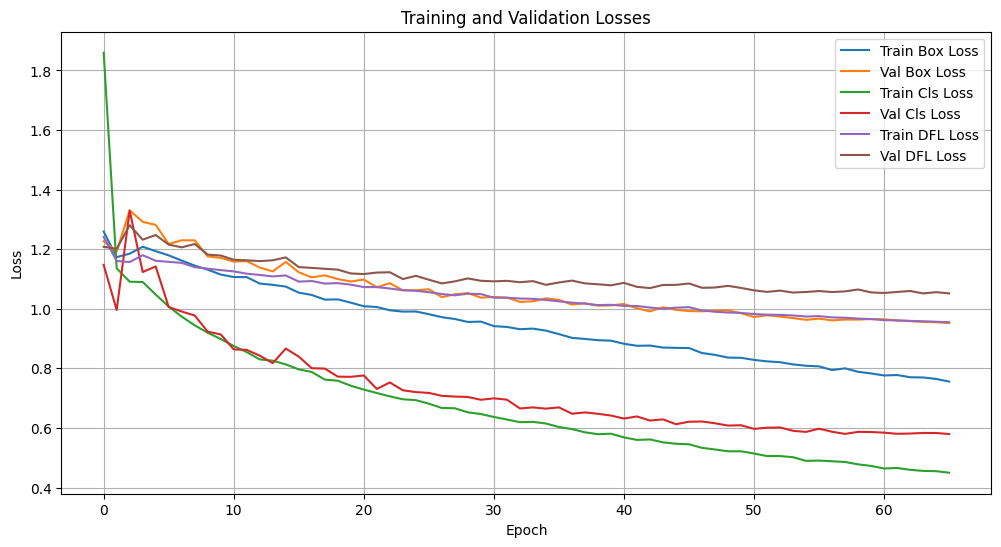

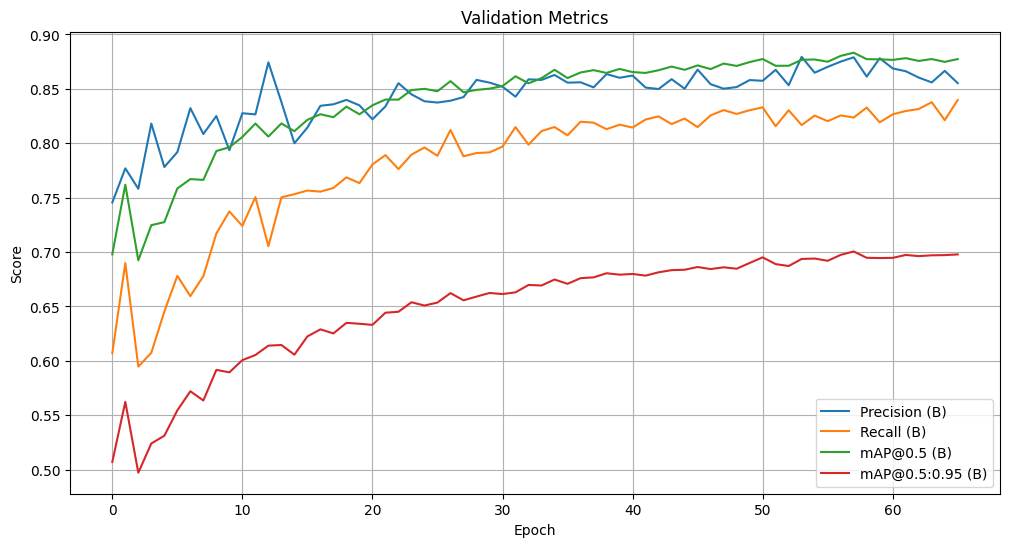

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and clean
df = pd.read_csv('/kaggle/working/fold_runs/fold_3/results.csv')
df.columns = df.columns.str.strip()  # Remove any leading/trailing whitespace

# Plot Losses
plt.figure(figsize=(12, 6))
plt.plot(df['train/box_loss'], label='Train Box Loss')
plt.plot(df['val/box_loss'], label='Val Box Loss')
plt.plot(df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['val/cls_loss'], label='Val Cls Loss')
plt.plot(df['train/dfl_loss'], label='Train DFL Loss')
plt.plot(df['val/dfl_loss'], label='Val DFL Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Metrics (Precision, Recall, mAP)
plt.figure(figsize=(12, 6))
plt.plot(df['metrics/precision(B)'], label='Precision (B)')
plt.plot(df['metrics/recall(B)'], label='Recall (B)')
plt.plot(df['metrics/mAP50(B)'], label='mAP@0.5 (B)')
plt.plot(df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95 (B)')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
